Набор данных содержить твитты пользователей за период с 01-01-2023 по 15-05-2023 и имеет следующие колонки:
- Tweet_ID - id пользователя совершившего твит
- Username - имя пользователя совершившего твит
- Text - текст твита
- Retweets - сколько людей сделали ретвит
- Likes - количество лайков
- Timestamp - время написания твита

В данной работе постараемся ответить на следующие вопросы:
1. Топ 5 записей по лайкам 
2. Топ 5 записей по ретвитам, проверим взаимосвязь между этими категориями, в этом нам поможет корреляция
3. Топ активных пользователей
4. Так же проверим влияние лайков и ретвитов на написание статей, для этого используем корреляцию
5. Построим график по ретвиттам и лайкам в разрезе по месяцам
6. Так же попробуем выделить часто используемые слова

In [31]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.formula.api as smf
import scipy
from scipy.stats import f_oneway
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import TextBlob
from wordcloud import WordCloud

OUTDATED_IGNORE=1
%matplotlib inline
os.getcwd()

'C:\\Users\\Илья\\Desktop\\тестовое\\Данные по твиттеру'

In [2]:
df = pd.read_csv('C:\\Users\\Илья\\Desktop\\тестовое\\Данные по твиттеру\\twitter_dataset.csv', sep=',',  parse_dates=['Timestamp'])

In [3]:
# Посмотрим какой формат данных мы имеем, а так же на количество строк и колонок.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Tweet_ID   10000 non-null  int64         
 1   Username   10000 non-null  object        
 2   Text       10000 non-null  object        
 3   Retweets   10000 non-null  int64         
 4   Likes      10000 non-null  int64         
 5   Timestamp  10000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 468.9+ KB


In [4]:
# Проверим данные на пустые значения, а так же на уникальность.
print(df.isna().sum())
print('------------------')
print(df.nunique())

Tweet_ID     0
Username     0
Text         0
Retweets     0
Likes        0
Timestamp    0
dtype: int64
------------------
Tweet_ID     10000
Username      9447
Text         10000
Retweets       101
Likes          101
Timestamp     9993
dtype: int64


Из полученных данных мы видим:
- У нас нет пропусков в колонках.
- Столбцы с ретвитами и лайками имеют одинаковое количество значений, это может говорить о том, что в этих колонках имеется много одинаковых числовых значений, по этому проверка на уникальность для данных столбцов не очень подходит.
- В столбце ***Username***, немного сократилось количество ползователей, это может нас сообщить о том, что число пользователей которые пишут много твитов не так уж и велико.
- Так же в колонке ***Timestamp***, число записей уменьшилось на 7, необходимо проверить что это за даты. Возможно в этот день происходили какие-то события которые повлияли на количество написания твитов.

В нашем наборе данных ***10 000 записей***, соответсвенно текст каждого твитта проверить самостоятельно на наличие спец. символов представляется затруднительным, поэтому мы используем регулярные выражения, которые выполнят всю работу за нас.

In [5]:
df['Text'] = df['Text'].str.replace('[^a-zA-Z0-9\s]', '')

C:\Users\Илья\AppData\Local\Temp\ipykernel_391972\2259295269.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Text'] = df['Text'].str.replace('[^a-zA-Z0-9\s]', '')


##### Задание 1.
- Определим ***Топ 5*** записей по количеству лайков, для этого сгруппируем по пользователю и посчитаем по каждому из них количество лайков.

In [6]:
top_Likes = df.groupby('Tweet_ID')['Likes'].sum().nlargest(5)
top_Likes

Tweet_ID
117    100
186    100
297    100
352    100
434    100
Name: Likes, dtype: int64

##### Задание 2.
- Определим ***Топ 5*** записей по количеству ретвиттов, для этого сгруппируем по пользователю и посчитаем по каждому из них количество ретвитов.

In [7]:
top_Retweets = df.groupby('Tweet_ID')['Retweets'].sum().nlargest(5)
top_Retweets

Tweet_ID
167    100
315    100
435    100
696    100
821    100
Name: Retweets, dtype: int64

Проверим корреляцию между ретвитами и лайками, но сперва посмотрим на распределение данных.

Text(0, 0.5, 'Quantity')

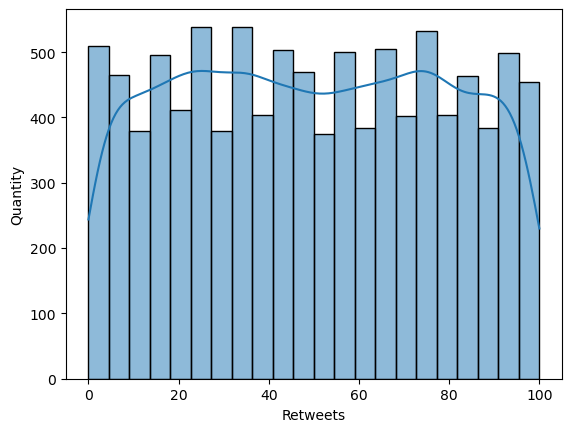

In [8]:
sns.histplot(df['Retweets'], kde=True)
plt.xlabel('Retweets')
plt.ylabel('Quantity')

Text(0, 0.5, 'Quantity')

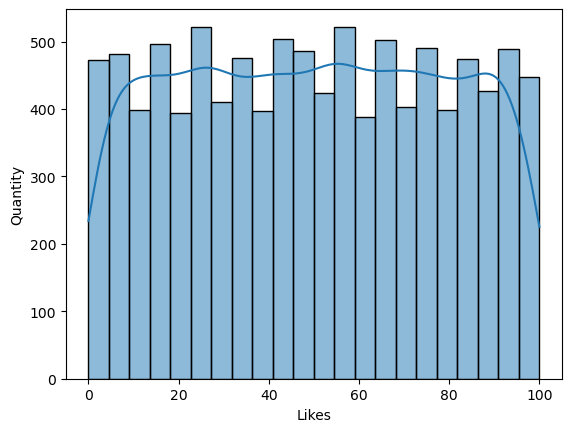

In [9]:
sns.histplot(df['Likes'], kde=True)
plt.xlabel('Likes')
plt.ylabel('Quantity')

In [10]:
# Рассчитаем медианные значения по лайкам и ретвитам и проверем корелляццию между ними.
median_Retweets = df.Retweets.median()
median_Likes = df.Likes.median()
correlation = (df['Retweets'].corr(df['Likes'])).round(2)

print(f'Медиана ретвиттов: {median_Retweets}')
print(f'Медиана лайков: {median_Likes}')
print(f'Корреляция между лайками и ретвиттами: {correlation}')

Медиана ретвиттов: 49.0
Медиана лайков: 50.0
Корреляция между лайками и ретвиттами: 0.01


Видим что у нас очень слабая зависимости лайков к ретвиттам, т.к. ***коэффициент корреляции*** стремиться к нулю.

##### Задание 3.
- Определим ***Топ*** активных пользователей по написанию постов.

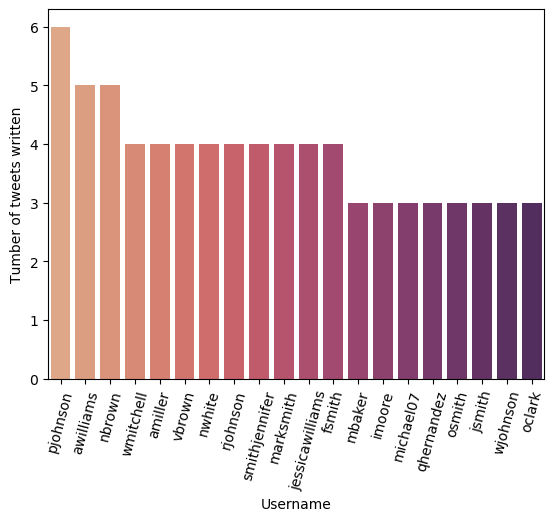

In [11]:
top_users = df.groupby('Username', as_index=False).agg({'Text' : 'count'}).sort_values('Text', ascending=False).reset_index().drop(columns='index').head(20)

sns.barplot(data=top_users, x="Username", y="Text", palette="flare")
plt.xticks(rotation=75)
plt.ylabel('Тumber of tweets written')
plt.show()

##### Задание 4.
- Проверим, как на написание постов будет влиять лайки и репосты.

Таким образом получим две гипотезы:

> H0 - лайки и репосты не стимулируют на написание твитов

> Н1 - лайки и репосты стимулируют написание твиттов

- Первая независимая переменная это ***Retweets***
- Вторая независимая переменная это ***Likes***
- Зависимая перменная, влияние на которую мы будем проверять это ***Text***

In [12]:
df_corr = df.groupby(['Username']).agg({'Text' : 'count', 'Likes' : 'sum', 'Retweets' : 'sum'}).sort_values(by=['Likes', 'Retweets'], ascending=False)

In [13]:
results = smf.ols('Text ~ Retweets + Likes', df_corr).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Text   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     2006.
Date:                Tue, 06 Jun 2023   Prob (F-statistic):               0.00
Time:                        14:04:04   Log-Likelihood:                 462.33
No. Observations:                9447   AIC:                            -918.7
Df Residuals:                    9444   BIC:                            -897.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7457      0.005    136.072      0.0

В результате проведенного исследования о взаимодействии двух НП на ЗП, мы имеем крайне низкий p-уровень значимости в размере ***0,000***, что позволяет нам отклонить Н0 и принять Н1. Так же в данных присутствует положительная связь между нашими переменными на что указывает колонка ***coef***. 

***Вывод***: Что бы стимулировать написание твиттов необходимо стимулировать пользователей ставить лайки и делать ретвитты. Но в свою очередь твитты должны быть интересными, что бы собирать лайки и ретвитты.

##### Задание 5.
- Построим график по ретвиттам и лайкам в разрезе по месяцам. 

Для этого разобьем наши данные оп ***месяцам***. 

Далее проверим динамику распределения лайков и ретвиттов ***внутри*** каждого месяца. А затем сравним ***средние*** показатели, при условии что данные будут распределенны нормально, за первые четыре месяца, потому как пятый месяц(май) у нас не полный. Если же окажется что данные имеют не нормальное распределние, то используем ***медиану*** для сравнения. Это нам поможет понять было ли у нас статистически значимое изменение этих показателей за установленный периоды.

In [14]:
df["Year_month_day"] = df["Timestamp"].dt.to_period("d")
df["Year_month_day"] = df["Year_month_day"].astype('datetime64[ns]')

In [15]:
January = df.query('Timestamp <= "2023-02-01"').groupby('Year_month_day', as_index=False) \
            .agg({'Retweets' : 'sum', 'Likes' : 'sum'}).sort_values('Year_month_day', ascending=True)

February = df.query('Timestamp > "2023-02-01" and Timestamp <= "2023-03-01"').groupby('Year_month_day', as_index=False) \
            .agg({'Retweets' : 'sum', 'Likes' : 'sum'}).sort_values('Year_month_day', ascending=True)

March = df.query('Timestamp > "2023-03-01" and Timestamp <= "2023-04-01"').groupby('Year_month_day', as_index=False) \
            .agg({'Retweets' : 'sum', 'Likes' : 'sum'}).sort_values('Year_month_day', ascending=True)

April = df.query('Timestamp > "2023-04-01" and Timestamp <= "2023-05-01"').groupby('Year_month_day', as_index=False) \
            .agg({'Retweets' : 'sum', 'Likes' : 'sum'}).sort_values('Year_month_day', ascending=True)

May = df.query('Timestamp > "2023-05-01"').groupby('Year_month_day', as_index=False) \
            .agg({'Retweets' : 'sum', 'Likes' : 'sum'}).sort_values('Year_month_day', ascending=True)

> График за Январь

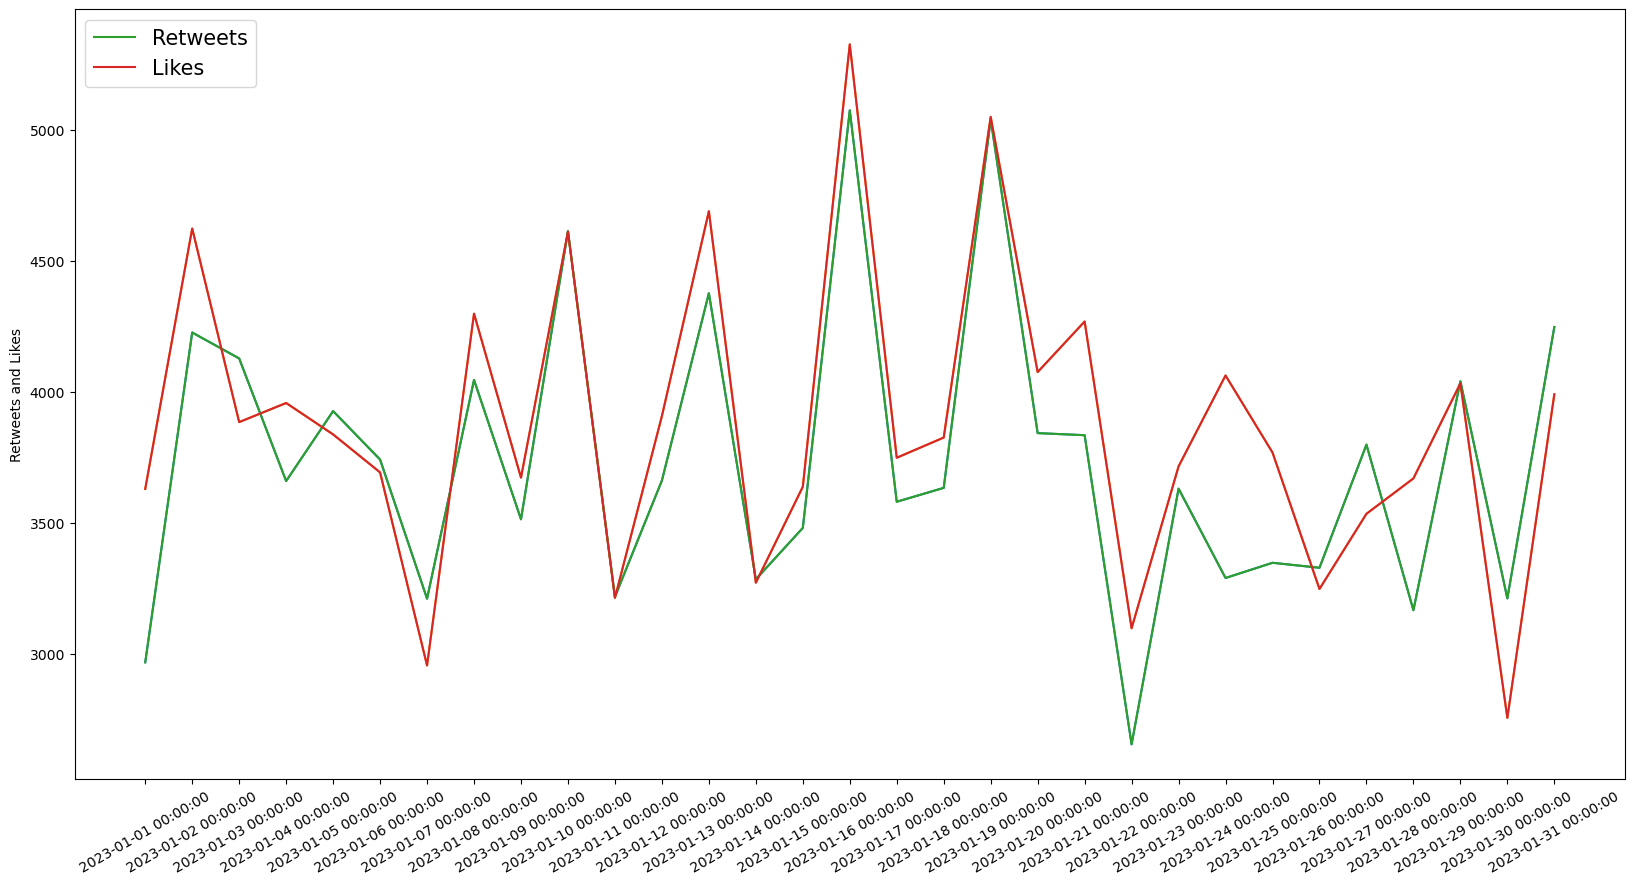

In [16]:
plt.figure(figsize = (20,10))
sns.lineplot(x = 'Year_month_day', y = 'Retweets', data = January)
sns.lineplot(x = 'Year_month_day', y = 'Likes', data = January)
x_ticks = January.Year_month_day
x_labels = January.Year_month_day
plt.rc('font', size=15 ) 
plt.xticks (ticks=x_ticks, labels=x_labels)

y1 = January.Retweets
y2 = January.Likes
plt.plot(x_ticks, y1, label="Retweets")
plt.plot(x_ticks, y2, label="Likes")
plt.legend(loc="upper left")

plt.xticks(rotation=30)
plt.xlabel('')
plt.ylabel('Retweets and Likes')
plt.show()

> График за Февраль

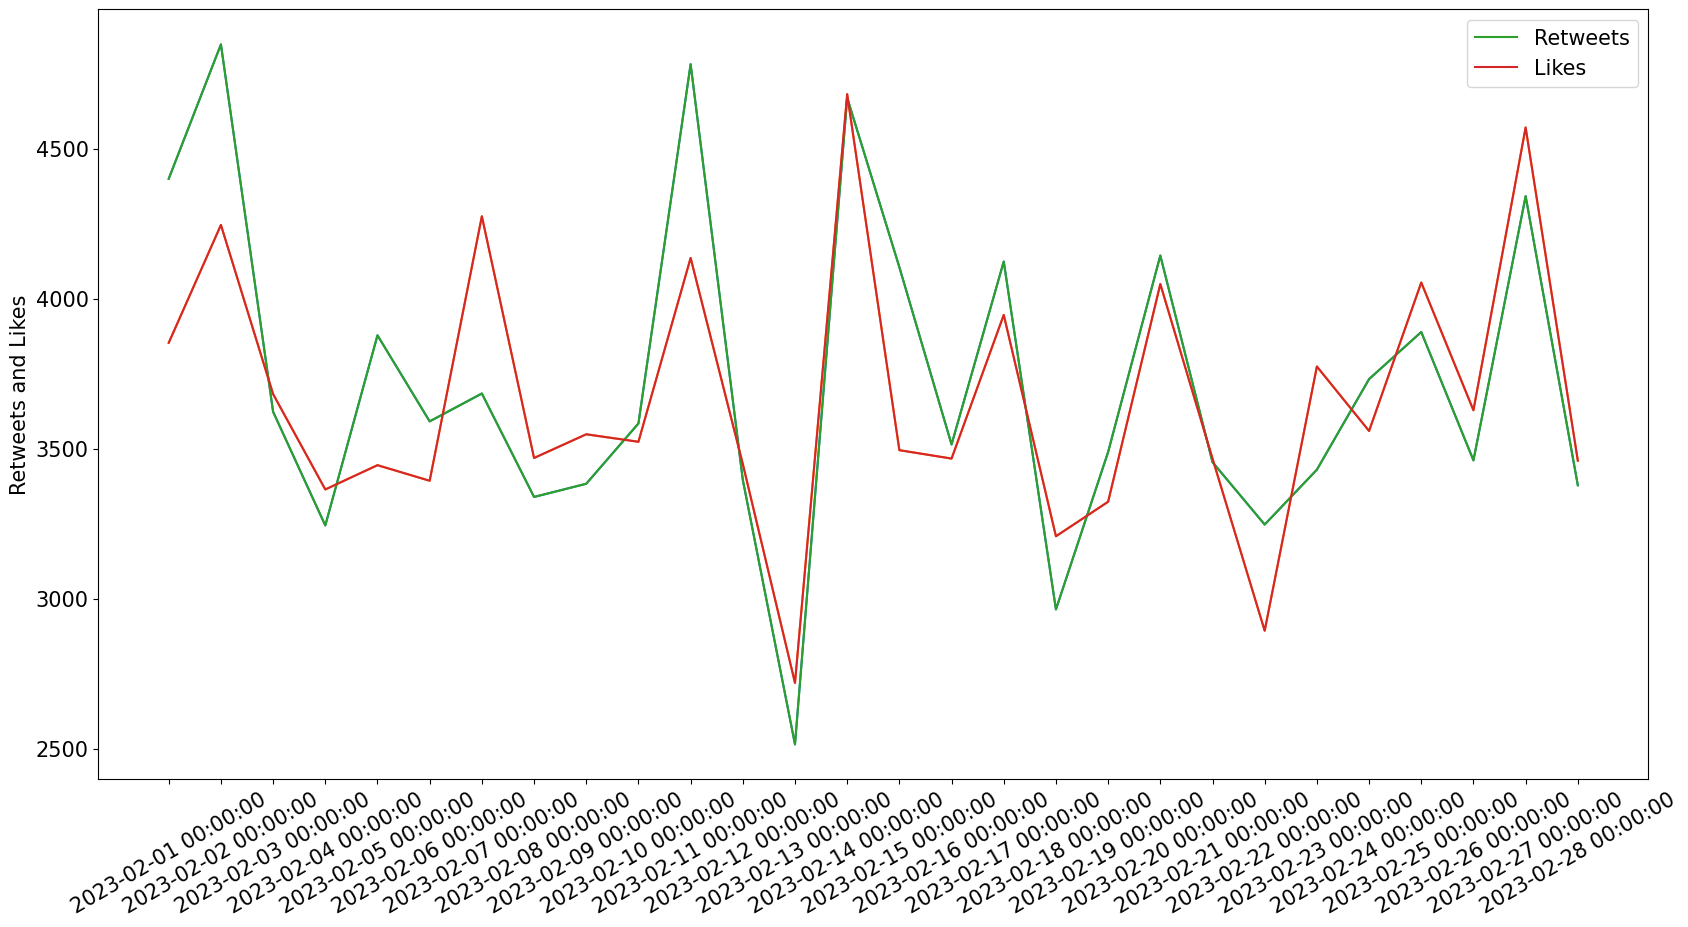

In [17]:
plt.figure(figsize = (20,10))
sns.lineplot(x = 'Year_month_day', y = 'Retweets', data = February)
sns.lineplot(x = 'Year_month_day', y = 'Likes', data = February)
x_ticks = February.Year_month_day
x_labels = February.Year_month_day
plt.rc('font', size=15 ) 
plt.xticks (ticks=x_ticks, labels=x_labels)

y1 = February.Retweets
y2 = February.Likes
plt.plot(x_ticks, y1, label="Retweets")
plt.plot(x_ticks, y2, label="Likes")
plt.legend(loc="upper right")

plt.xticks(rotation=30)
plt.xlabel('')
plt.ylabel('Retweets and Likes')
plt.show()

> График за Март

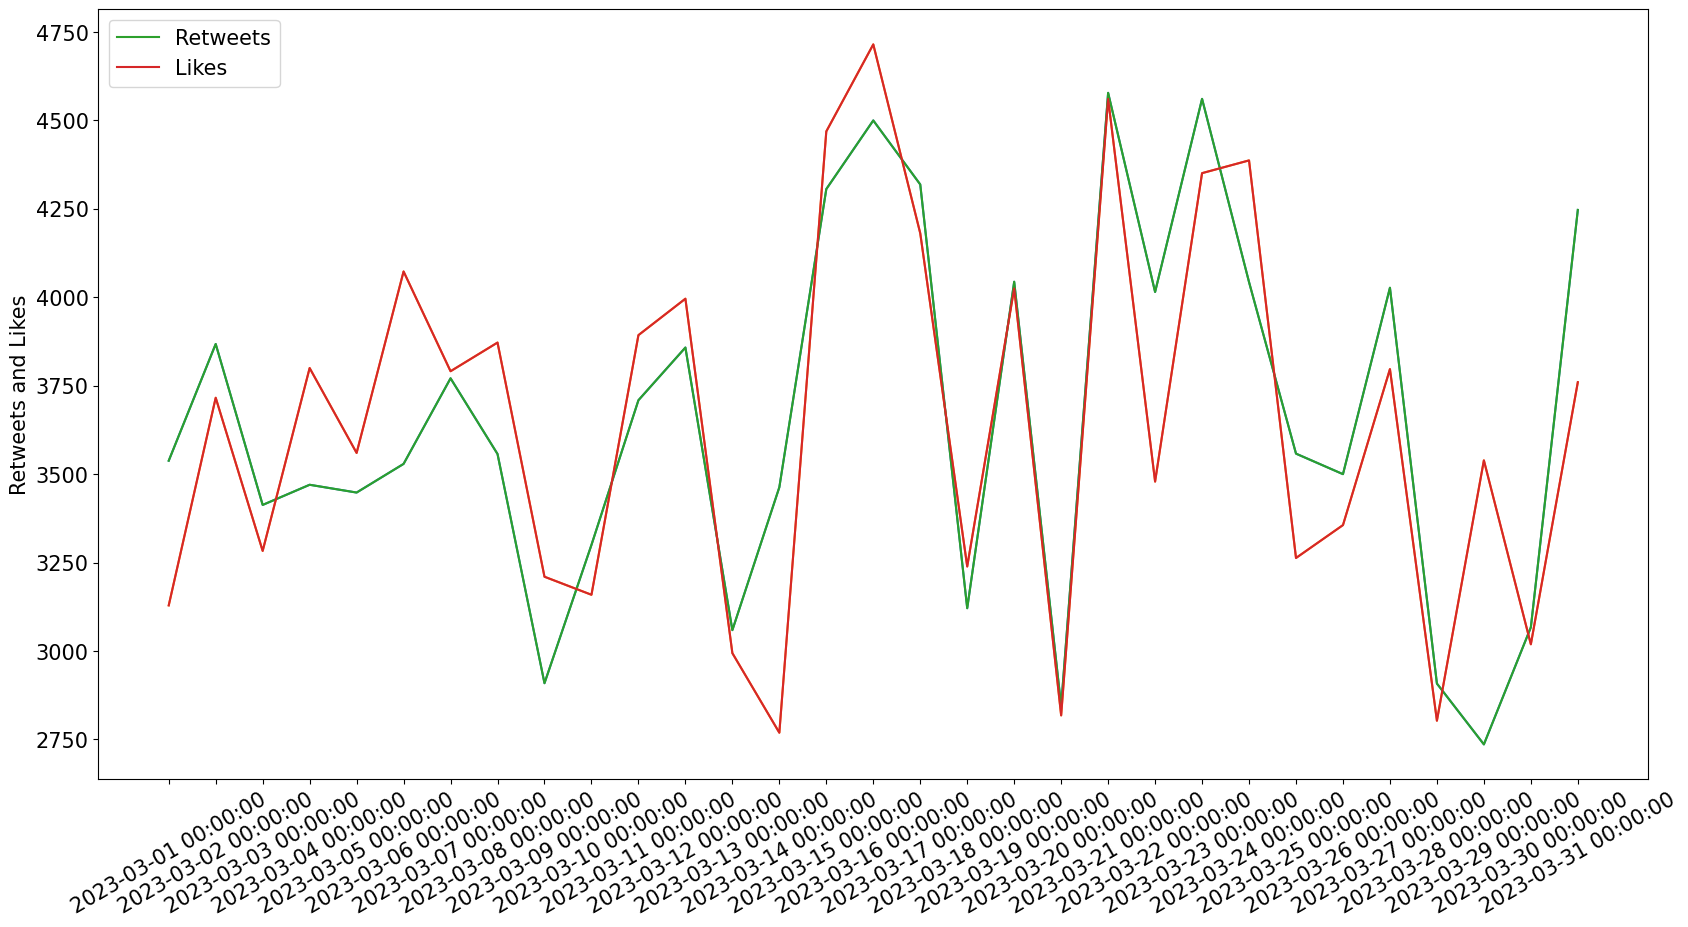

In [18]:
plt.figure(figsize = (20,10))
sns.lineplot(x = 'Year_month_day', y = 'Retweets', data = March)
sns.lineplot(x = 'Year_month_day', y = 'Likes', data = March)
x_ticks = March.Year_month_day
x_labels = March.Year_month_day
plt.rc('font', size=15 ) 
plt.xticks (ticks=x_ticks, labels=x_labels)

y1 = March.Retweets
y2 = March.Likes
plt.plot(x_ticks, y1, label="Retweets")
plt.plot(x_ticks, y2, label="Likes")
plt.legend(loc="upper left")

plt.xticks(rotation=30)
plt.xlabel('')
plt.ylabel('Retweets and Likes')
plt.show()

> График за Апрель

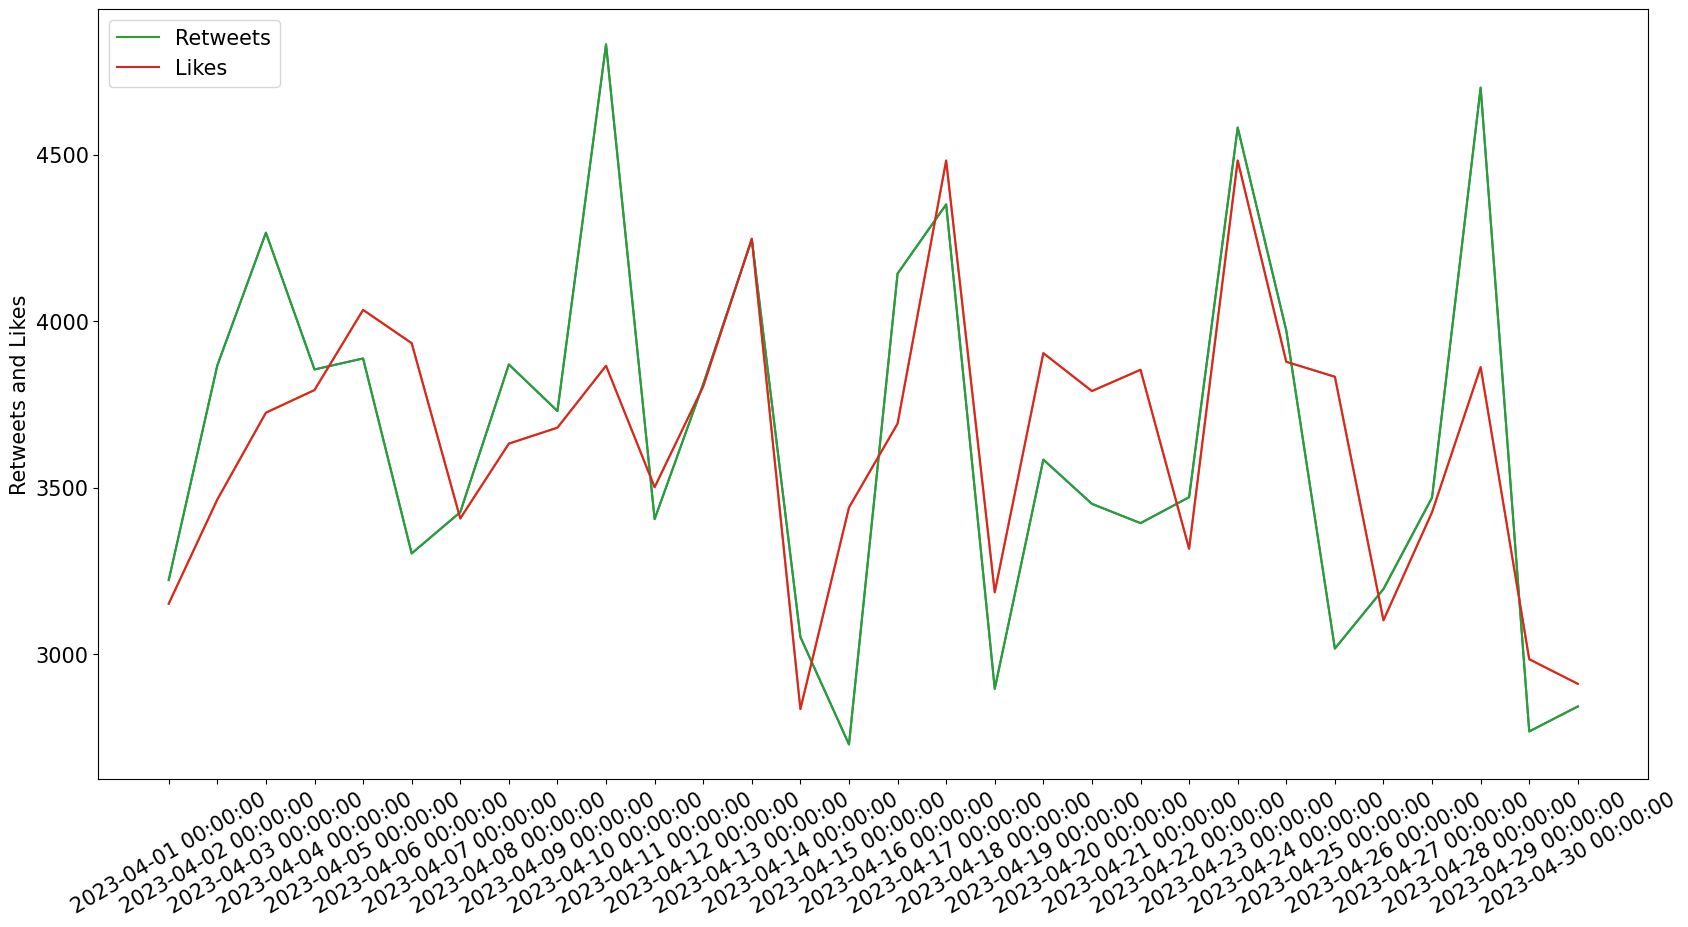

In [19]:
plt.figure(figsize = (20,10))
sns.lineplot(x = 'Year_month_day', y = 'Retweets', data = April)
sns.lineplot(x = 'Year_month_day', y = 'Likes', data = April)
x_ticks = April.Year_month_day
x_labels = April.Year_month_day
plt.rc('font', size=15 ) 
plt.xticks (ticks=x_ticks, labels=x_labels)

y1 = April.Retweets
y2 = April.Likes
plt.plot(x_ticks, y1, label="Retweets")
plt.plot(x_ticks, y2, label="Likes")
plt.legend(loc="upper left")

plt.xticks(rotation=30)
plt.xlabel('')
plt.ylabel('Retweets and Likes')
plt.show()

> График за Май

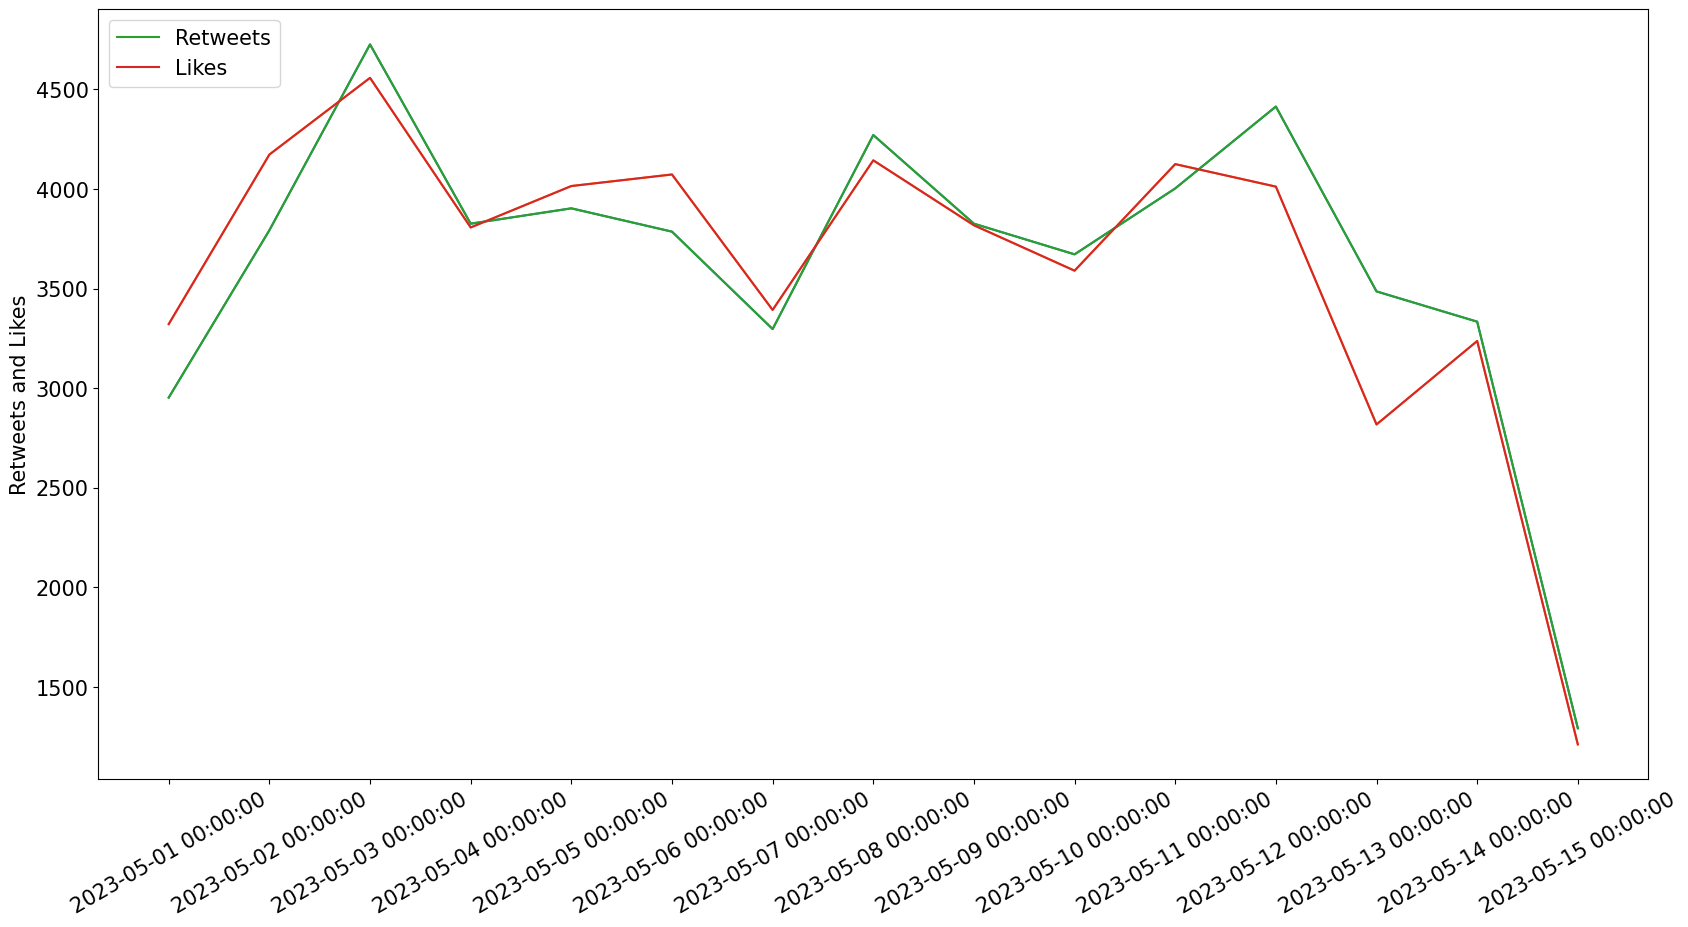

In [20]:
plt.figure(figsize = (20,10))
sns.lineplot(x = 'Year_month_day', y = 'Retweets', data = May)
sns.lineplot(x = 'Year_month_day', y = 'Likes', data = May)
x_ticks = May.Year_month_day
x_labels = May.Year_month_day
plt.rc('font', size=15 ) 
plt.xticks (ticks=x_ticks, labels=x_labels)

y1 = May.Retweets
y2 = May.Likes
plt.plot(x_ticks, y1, label="Retweets")
plt.plot(x_ticks, y2, label="Likes")
plt.legend(loc="upper left")


plt.xticks(rotation=30)
plt.xlabel('')
plt.ylabel('Retweets and Likes')
plt.show()

По построенным графикам видим, что как ***лайки*** так и ***ретвитты*** практически равномерно распределены по подням. Но иногда так же встречаются дни в которых больше ***ретвиттов*** или ***лайков***. 

Из этого можно сделать следующие выводы:
1. Были написанны интересные статьи которые набирали примерно равное кол-во ***лайков*** и ***ретвиттов***.
2. Были написанны статьи, которые вызывали определенный интерес, возможно негативный, благодаря чему не вызывали одобрения в ввиде ***лайка***, но провоцировали делать ***ретвитты***.
3. Были написанны статьи, которые понравились очень узкому кругу лиц или были опубликованны в закрытых аккаунтах, ввиду чего не набрали много ***ретвиттов***, но собрали много ***лайков*** по целевой аудитории.

Далее мы проведем анализ ретвиттов и лайков помесячно. Это позволит нам понять имеется ли у нас рост или все таки снижение этих показателей.

In [21]:
January["Year_month_day"] = January["Year_month_day"].dt.to_period("m")
February["Year_month_day"] = February["Year_month_day"].dt.to_period("m")
March["Year_month_day"] = March["Year_month_day"].dt.to_period("m")
April["Year_month_day"] = April["Year_month_day"].dt.to_period("m")
May["Year_month_day"] = May["Year_month_day"].dt.to_period("m")

In [23]:
df_1 = January.groupby('Year_month_day', as_index=False).agg({'Retweets':'sum', 'Likes':'sum'}) \
    .rename(columns={'Year_month_day':'Month'})

df_2 = February.groupby('Year_month_day', as_index=False).agg({'Retweets':'sum', 'Likes':'sum'}) \
    .rename(columns={'Year_month_day':'Month'})

df_3 = March.groupby('Year_month_day', as_index=False).agg({'Retweets':'sum', 'Likes':'sum'}) \
    .rename(columns={'Year_month_day':'Month'})

df_4 = April.groupby('Year_month_day', as_index=False).agg({'Retweets':'sum', 'Likes':'sum'}) \
    .rename(columns={'Year_month_day':'Month'})

df_5 = May.groupby('Year_month_day', as_index=False).agg({'Retweets':'sum', 'Likes':'sum'}) \
    .rename(columns={'Year_month_day':'Month'})

In [24]:
month_df = pd.concat([df_1, df_2, df_3, df_4, df_5], axis=0)

In [25]:
month_df = month_df.reset_index().drop(columns={'index'})

In [26]:
month_df.Month = month_df.Month.astype('datetime64[ns]')

In [28]:
month_df['Month'] = month_df['Month'].replace({'2023-01':'January', '2023-02':'February', '2023-03':'March', '2023-04':'April', '2023-05':'May'})

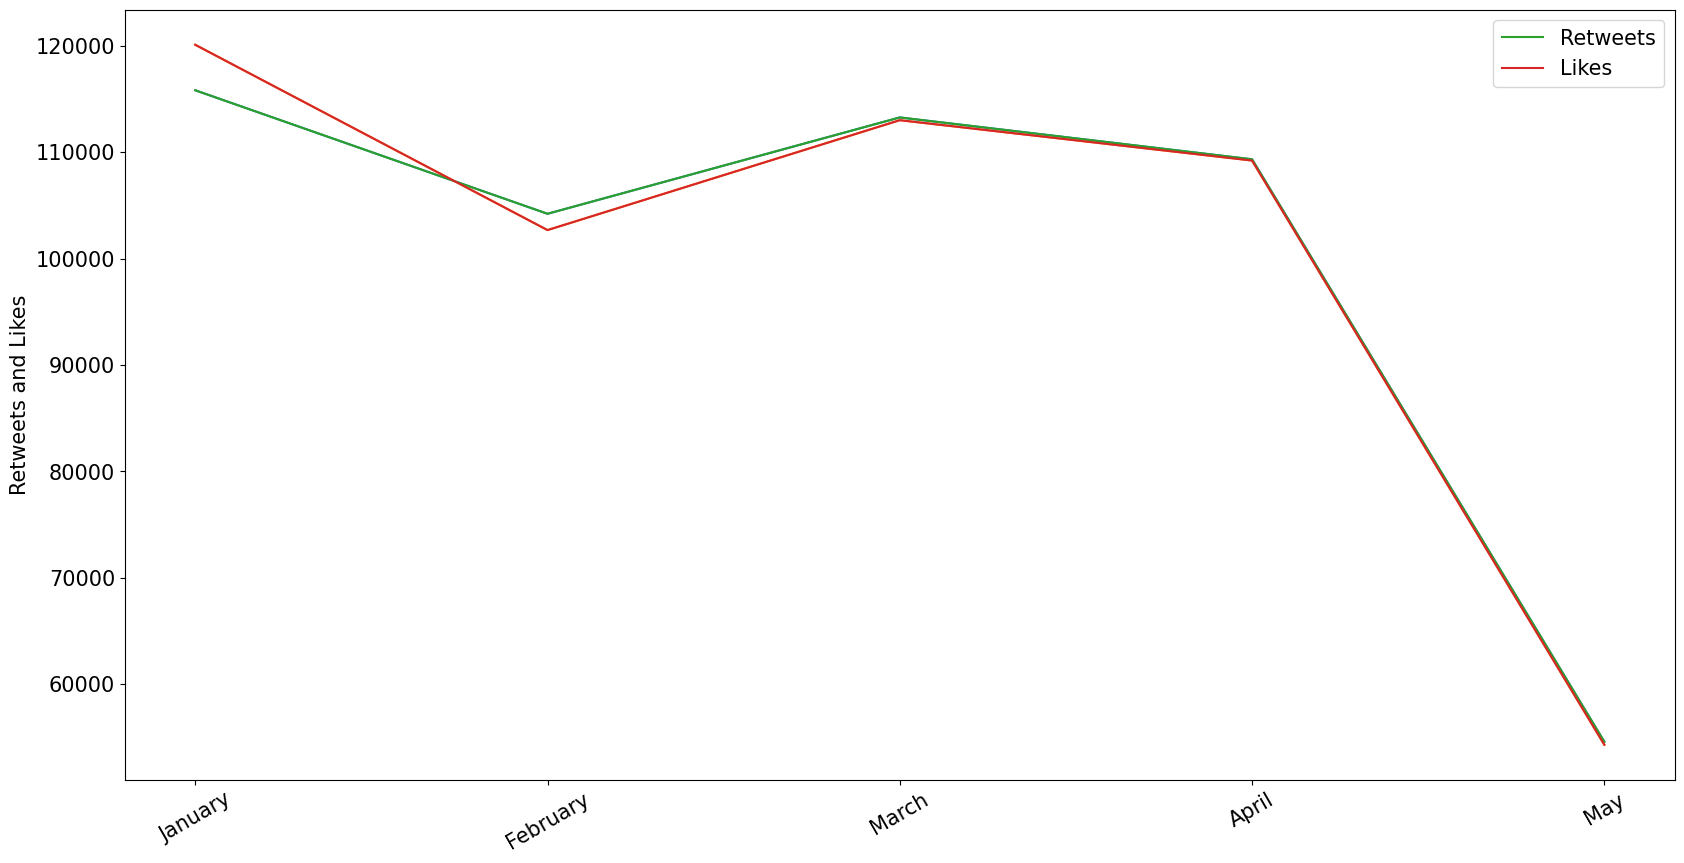

In [30]:
plt.figure(figsize = (20,10))
sns.lineplot(x = 'Month', y = 'Retweets', data = month_df)
sns.lineplot(x = 'Month', y = 'Likes', data = month_df)
x_ticks = month_df.Month
x_labels = month_df.Month
plt.rc('font', size=15 ) 
plt.xticks (ticks=x_ticks, labels=x_labels)

y1 = month_df.Retweets
y2 = month_df.Likes
plt.plot(x_ticks, y1, label="Retweets")
plt.plot(x_ticks, y2, label="Likes")
plt.legend(loc="upper right")


plt.xticks(rotation=30)
plt.xlabel('')
plt.ylabel('Retweets and Likes')
plt.show()

##### Задание 6.
- Так же попробуем выделить часто используемые слова.

In [45]:
# Токенизировать текст твита
df['tokens'] = df['Text'].apply(lambda x: nltk.word_tokenize(x))

# Удалить стоп-слова
stop_words = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word.lower() not in stop_words])

# Стемминг или лемматизация
stemmer = PorterStemmer()
df['tokens'] = df['tokens'].apply(lambda x: [stemmer.stem(word) for word in x])

# Выполните анализ настроений по тексту твита
df['sentiment_polarity'] = df['Text'].apply(lambda x: TextBlob(x).sentiment.polarity)

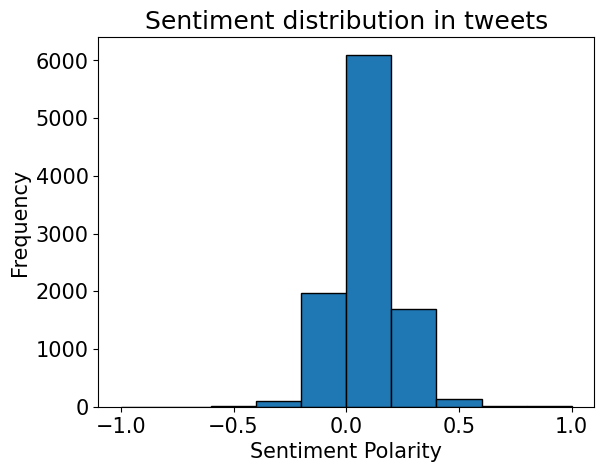

In [44]:
# График распределения полярности настроений
plt.hist(df['sentiment_polarity'], bins=10, range=(-1, 1), edgecolor='black')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.title('Sentiment distribution in tweets')
plt.show()

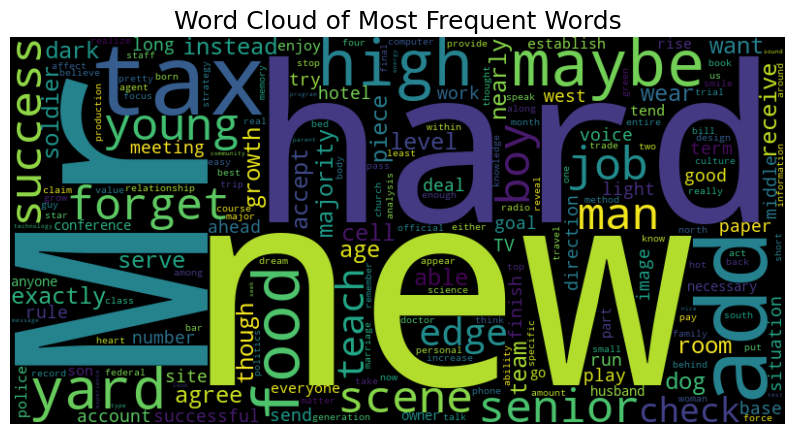

In [39]:
# Карта часто встречающихся слов
all_text = ' '.join(df['Text'])

wordcloud = WordCloud(width=800, height=400).generate(all_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Words')
plt.show()

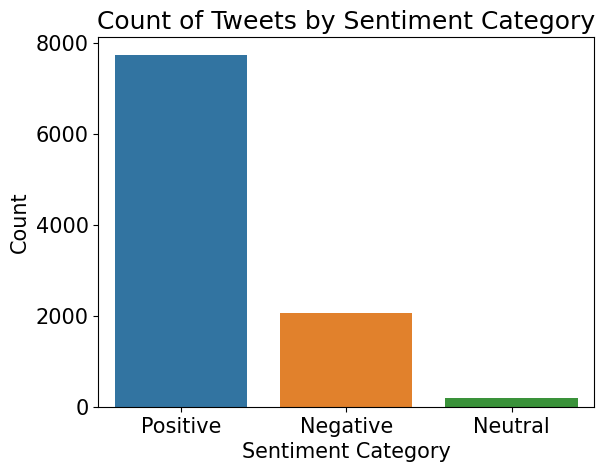

In [43]:
# Анализ настроений по тексту твита
df['Sentiment'] = df['Text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Разделение эмоции на положительные, отрицательные и нейтральные
df['Sentiment Category'] = df['Sentiment'].apply(lambda x: 'Positive' if x > 0 else 'Negative' if x < 0 else 'Neutral')

# Рассчитать количество каждой категории настроений
sentiment_counts = df['Sentiment Category'].value_counts()

# Постройте диаграмму распределения настроений
sns.countplot(x='Sentiment Category', data=df)
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.title('Count of Tweets by Sentiment Category')
plt.show()